## ALGO MAS QUE LECTURA INTELIGENTE... PREDICTIVA

El análisis de datos fiables y en cantidad suficiente permite al profesional bajar de la visión general que le puede proporcionar su experiencia, a la interpretación de los detalles.

La telelectura cuartohoraria de contadores es el valor más detallado de los caudales de agua que circulan en una red de distribución. Su predicción tratando las series temporales con técnicas de aprendizaje automático profundo, aunque pueda no ser muy precisa para el valor de un momento determinado, puede llegar a precisiones sorprendentes al incluirse grandes conjuntos de contadores.

El código muestra a nivel básico como funcionan estas tecnologías para un solo contador.

In [1]:
### ############################################################
### Prediccion de Telelectura de contadores de agua con RN LSTM
### Jose Maria de Cuenca
### ############################################################

# Cargo librerias generales
import time # Cronometro para el modelo
import numpy as np # Algebra de matrices
import pandas as pd # Procesado de datos
import seaborn as sns # Estadistica

import matplotlib.pyplot as plt # Graficos
import tensorflow as tf # Redes neuronales

# Cargo funciones
from sklearn.preprocessing import MinMaxScaler # Reescalado de conjuntos de valores

# Carga de datos

In [2]:
# Cargo dataset indicando una lista con los nombres de columnas ya que el csv importado no las tiene
df = pd.read_csv("telelectura.csv", header=None, names=['inicio', 'final', 'pulsos'])


In [3]:
# Como la fecha en csv se guarda en memoria como un objeto, lo cambio a formato fecha de Pandas, el paquete de procesado de datos
df['inicio'] = pd.to_datetime(df['inicio'])

# Compruebo el tipo de datos
print("Data Types:", df.dtypes)

# Muestro primeros registros del dataset
df.head(7)

Data Types: inicio    datetime64[ns]
final             object
pulsos             int64
dtype: object


,inicio,final,pulsos
0,2019-11-23 23:47:55,2019-11-24 00:02:54,8
1,2019-11-24 00:02:54,2019-11-24 00:17:53,0
2,2019-11-24 00:17:53,2019-11-24 00:32:51,0
3,2019-11-24 00:32:51,2019-11-24 00:47:50,0
4,2019-11-24 00:47:50,2019-11-24 01:02:49,0
5,2019-11-24 01:02:49,2019-11-24 01:17:47,0
6,2019-11-24 01:17:47,2019-11-24 01:32:46,0


In [4]:
# Reescribo las columnas de fechas con su contenido en formato de fecha (entro como object desde el csv)
df['inicio'] = pd.to_datetime(df['inicio'], format="%Y-%m-%d %H:%M:%S")
df['final'] = pd.to_datetime(df['final'], format="%Y-%m-%d %H:%M:%S")

# El tipo de dato DtetimeIndex permite a Pandas interpretar el dataframe como una serie temporal.
# https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior

# Compruebo el cambio
print("Data Types:", df.dtypes)

# Muestro primeros registros del dataset
df.head(7)

Data Types: inicio    datetime64[ns]
final     datetime64[ns]
pulsos             int64
dtype: object


,inicio,final,pulsos
0,2019-11-23 23:47:55,2019-11-24 00:02:54,8
1,2019-11-24 00:02:54,2019-11-24 00:17:53,0
2,2019-11-24 00:17:53,2019-11-24 00:32:51,0
3,2019-11-24 00:32:51,2019-11-24 00:47:50,0
4,2019-11-24 00:47:50,2019-11-24 01:02:49,0
5,2019-11-24 01:02:49,2019-11-24 01:17:47,0
6,2019-11-24 01:17:47,2019-11-24 01:32:46,0


In [5]:
# Creo nuevo dataset con solo las 2 columnas originales, fecha y pulsos

# Defino diccionario para extraccion de las columnas
dict_df={'ds':df['inicio'],'y':df['pulsos']}

# Creo el nuevo dataframe pandas
lstm_df=pd.DataFrame(data=dict_df)

# Reindexo con el campo de fecha, necesario para poder operar
lstm_df=lstm_df.set_index('ds')

# Muestro de nuevo los tipos de datos y el dataset simplificado
print("Data Types:", lstm_df.dtypes)

lstm_df.head()

# Vemos que ahora la fecha de inicio aparece en negrita: es el índice de los datos

Data Types: y    int64
dtype: object


,y
ds,
2019-11-23 23:47:55,8
2019-11-24 00:02:54,0
2019-11-24 00:17:53,0
2019-11-24 00:32:51,0
2019-11-24 00:47:50,0


### Representación de los datos

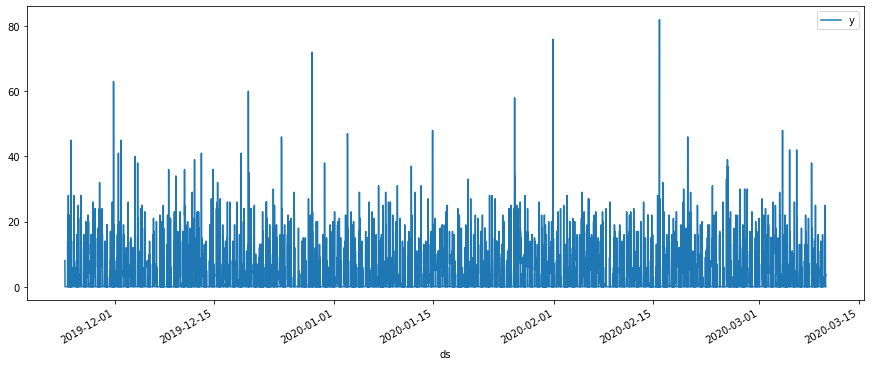

In [6]:
# Dibujo serie temporal remuestreada
lstm_df.plot(figsize=(15, 6))

plt.show()

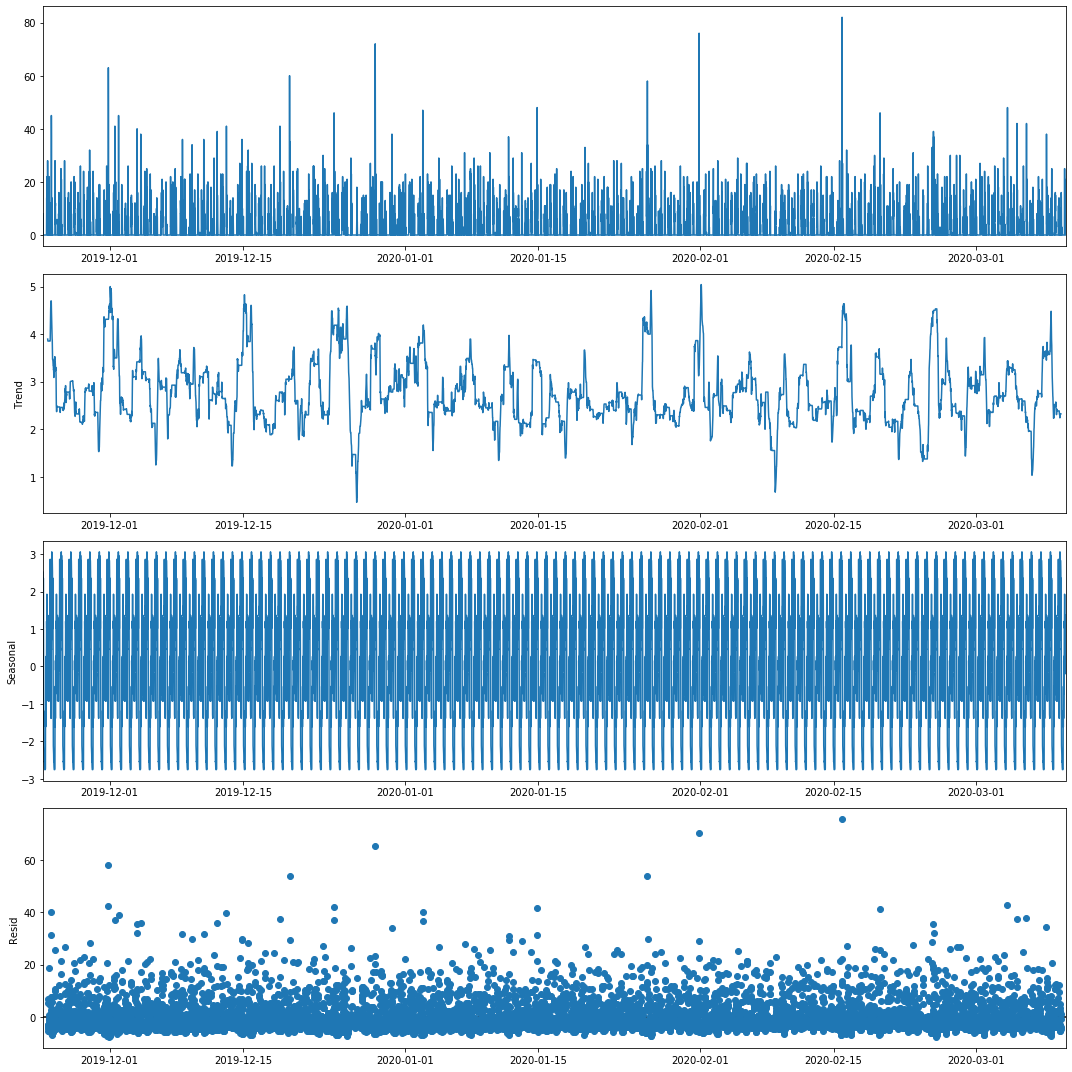

In [7]:
# Analizo los componentes de los datos para buscar tendencia, estacionalidad y residuos

# Carbo las funciones necesarias
from pylab import rcParams # Reescala los graficos por defecto
import statsmodels.api as sm # Analisis estadistico

rcParams['figure.figsize'] = 15, 15 # Tamaño del grafico
decomposition = sm.tsa.seasonal_decompose(lstm_df, model='additive', period=96) # Descomposición
fig = decomposition.plot() # Pongo la descomposición en el grafico
plt.show() # Muestro el grafico

# Vemos que la estacionalidad recoge poca variacion (-3 a 3) y es mucho menor que el residuo (20 de media)
# Luego la descomposicion esta forzada, lo que limitará el uso de modelos por medias, etc.

# Modelo LSTM

In [8]:
# Normalizo el dataset para ajustar los datos en el rango (0,1)

# Defino modelo tipo StandarScaler (sc) para ajustar rango
sc = MinMaxScaler(feature_range = (0, 1))

# Transformo los datos en una nueva lista escalada
lstm_scaled = sc.fit_transform(lstm_df)

In [9]:
# Creo manualmente conjuntos de entrenamiento y prueba. Se podria hacer con train_split

# Conjunto de entrenamiento con hasta el 80% de los datos, de test con el restante 20% de los datos
train_size = int(len(lstm_scaled) * 0.80)
test_size = len(lstm_scaled) - train_size

# Creo los conjuntos como particiones del dataset normalizado
train, test = lstm_scaled[0:train_size, :], lstm_scaled[train_size:len(lstm_scaled), :]

In [10]:
# Muestro los datos para entrenamiento, ya sin la fecha
print(train)

[[0.09756098]
 [0.        ]
 [0.        ]
 ...
 [0.25609756]
 [0.        ]
 [0.1097561 ]]


In [11]:
## Creo una funcion para crear una matriz que recoja en columnas adicionales los datos retrasados de un conjunto
## Uso una funcion para poder aplicarla varias veces, una para los datos de entrenamiento y otra con los de test

# El arreglo numpy tendrá tantas columnas de valores retrasados como indico en window. De momento pongo 1 por defecto.
# La primera columna sera la serie temporal
# La segunda los valores de la serie temporal retrasados una posicicion temporal, etc
def create_data_set(dataset, window=1):
    # Defino dos matrices vacias por conjunto, una para poner los datos y otra las etiquetas
    data, label =[],[]
    # Vamos recorriendo el conjunto sacando secuencias de longitud fija (window) y poniendolas en la matriz
    # La recorro hasta la diferencia de numero de filas menos la ventana menos uno, para no tener valores NaN
    for i in range( len(dataset) - window - 1 ):
        d = dataset[ i:( i+window ), 0 ]
        # Añado dato a dato la secuencia a la matriz de datos
        data.append(d)
        # Añado la etiqueta del dato a la matriz de resultados
        label.append(dataset[i+window,0])
    return np.array(data), np.array(label)

In [12]:
## Preparo las matrices con los datos de entrenamiento y test

look_back =96 # Defino ventana de 96 datos anteriores que usará para predecir el siguiente con la RN LSTM
X_train,Y_train,X_test,Ytest = [],[],[],[] # Creo cuatro matrices vacias

# Uso la funcion con el conjunto de entrenamiento para rellenar las matrices
X_train,Y_train = create_data_set(train, look_back)
print('Forma de la matriz: ', X_train.shape)
print('\nMuestra X_train:\n', X_train)

# Uso la funcion con el conjunto de datos
X_test,Y_test = create_data_set(test, look_back)

# Vemos que la serie temporal tiene el mismo numero de datos, pero se han añadido tantas columnas
# como valores retrasados consideraremos para estudiar cada dato

Forma de la matriz:  (8161, 96)

Muestra X_train:
 [[0.09756098 0.         0.         ... 0.         0.07317073 0.        ]
 [0.         0.         0.         ... 0.07317073 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.12195122 ... 0.         0.06097561 0.        ]
 [0.         0.12195122 0.02439024 ... 0.06097561 0.         0.18292683]
 [0.12195122 0.02439024 0.14634146 ... 0.         0.18292683 0.25609756]]


In [13]:
# Necesitamos hacer un reshape de las secuencias de datos para que puedan ser introducirdas
# correctamente en el modelo de RN LSTM, como un arreglo de ventanas de n datos

# La entrada para LSTM debe ser un arreglo 3D de (muestras, pasos de tiempo, caracteristicas)
# Las muestras son el numero de muestras en los datos de entrada
# Los pasos de tiempo son el numero de lags por muestra (valores anteriores de la ventana look_back)
# Las características son el numero de valores por pasos de tiempo por muestra (1 si hay un dato de volumen de agua consumida)

# Cambio la forma de las matrices de datos de entrenamiento y prueba
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Muestro la primera, con datos de entrenamiento
print('Forma de la matriz: ', X_train.shape)
print('\nMuestra X_train:\n', X_train)

Forma de la matriz:  (8161, 96, 1)

Muestra X_train:
 [[[0.09756098]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.07317073]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.07317073]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 ...

 [[0.        ]
  [0.        ]
  [0.12195122]
  ...
  [0.        ]
  [0.06097561]
  [0.        ]]

 [[0.        ]
  [0.12195122]
  [0.02439024]
  ...
  [0.06097561]
  [0.        ]
  [0.18292683]]

 [[0.12195122]
  [0.02439024]
  [0.14634146]
  ...
  [0.        ]
  [0.18292683]
  [0.25609756]]]


In [14]:
# Muestro la de test
print('Forma de la matriz: ', X_test.shape)
print('\nMuestra X_test:\n', X_test)

Forma de la matriz:  (1968, 96, 1)

Muestra X_test:
 [[[0.01219512]
  [0.09756098]
  [0.20731707]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.09756098]
  [0.20731707]
  [0.08536585]
  ...
  [0.        ]
  [0.        ]
  [0.20731707]]

 [[0.20731707]
  [0.08536585]
  [0.        ]
  ...
  [0.        ]
  [0.20731707]
  [0.04878049]]

 ...

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.18292683]
  [0.03658537]
  [0.04878049]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.03658537]
  [0.04878049]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.04878049]
  [0.        ]
  [0.        ]]]


In [15]:
# Dejo la matriz de etiquetas o resultados tal cual
print('Forma de la matriz: ', Y_train.shape)
print('\nMuestra Y_train:\n', Y_train)

Forma de la matriz:  (8161,)

Muestra Y_train:
 [0.         0.         0.         ... 0.18292683 0.25609756 0.        ]


In [16]:
## Creo modelo de red neuronal con regresor LSTM

# Cargo las funciones de Keras que facilitarán el trabajo
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Cargo funciones para obtener metricas
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error


# Defino la red neuronal como un modelo Keras de manera secuencial
model_RN_LSTM = Sequential()

# Primera capa LSTM con 96 celdas. Se puede reducir si reducimos la ventana de retraso
# La RN necesita conocer la dimensionalidad del input que deben esperar
# Por ello especifico el tamaño del dato en la primera capa (y sólo en la primera capa)
# Ademas permito acceder a la salida de estado oculto para cada paso de tiempo de entrada (return_sequences)
# Esto da una salida con las mismas dimensiones que la entrada

# El formato de entrada a la primera capa es (96,1) ya que los datos tienen 96 pasos de ventana con 1 caracteristica (el valor de volumen consumido)
model_RN_LSTM.add(LSTM(units = 96, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Capa de dropout para regularizar el modelo. En cada iteración elimina aleatoriamente el 10% de los valores para evitar sobreajustes a los datos
model_RN_LSTM.add(Dropout(0.1))

# Segunda capa LSTM y dropout
# Esta capa mantiene las dimensiones de la entrada de la original y da una salida igual (true_sequences)
model_RN_LSTM.add(LSTM(units = 96, return_sequences = True))
model_RN_LSTM.add(Dropout(0.1))

# Tercera capa LSTM y dropout
# Reduzco las dimensiones para ir concentrando los detalles de los datos
model_RN_LSTM.add(LSTM(units = 24))
model_RN_LSTM.add(Dropout(0.1))

# Capa completamente conectada para salida con 1 sola neurona, para predecir solo el siguiente valor
model_RN_LSTM.add(Dense(units = 1))

# Compilo la red con optiizador adam
model_RN_LSTM.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Informo sobre el modelo que acabo de definir
print(model_RN_LSTM.summary())

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 96, 96)            37632     
_________________________________________________________________
dropout_1 (Dropout)          (None, 96, 96)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 96, 96)            74112     
_________________________________________________________________
dropout_2 (Dropout)          (None, 96, 96)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 24)                11616     
_________________________________________________________________
dropout_3 (Dropout)          (None, 24)                0         
______________________

In [17]:
## Defino CALLBACKS para entrenamiento en Keras, una utilidad que persiste los datos tras cada epoca de entrenamiento

# Guardo las devoluciones de llamada (resultados intermedios) en una lista
# para poder guardar entrenamiento con pasos intermedios, es necesario en modelos complejos

# Defino el archivo yen la ruta donde guardará los resultados
filepath="weights.best.keras.LSTM.hdf5"

# Defino el objeto de callback checkpoint
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')


## Utilidad KERAS para ajustar automaticamente la tasa de aprendizaje

# Reduzco automaticamente la tasa de aprendizaje cuando la metrica deja de mejorar, para ajustar mejor en menos epocas
# patience es el numero de epocas que se toleran sin mejora antes de reducir tasa de aprendizaje
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=4)

In [18]:
# EJECUTO MODELO

# Inicio el cronometro para el entrenamiento del modelo
start_time = time.time()

# Entreno el modelo de RN LSTM, con 20 iteracciones o epocas, y uso los datos de test para validarlo
history = model_RN_LSTM.fit(X_train, Y_train, epochs = 20, batch_size = 15, validation_data=(X_test, Y_test), callbacks=[reduce_lr, checkpoint], shuffle=False)

# Detengo el cronometro
end_time = time.time()

# Informo del valor del cronometro (tiempo total de entrenamiento)
dt = round(end_time - start_time, 2)
print("El entrenamiento del modelo RN LSTM tarda: ", dt, "segundos (", round(dt/60,1) , "minutos)")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 8161 samples, validate on 1968 samples
Epoch 1/20





8161/8161 [==============================] - 62s 8ms/step - loss: 0.0047 - val_loss: 0.0043

Epoch 00001: loss improved from inf to 0.00472, saving model to weights.best.keras.LSTM.hdf5
Epoch 2/20
8161/8161 [==============================] - 62s 8ms/step - loss: 0.0045 - val_loss: 0.0042

Epoch 00002: loss improved from 0.00472 to 0.00446, saving model to weights.best.keras.LSTM.hdf5
Epoch 3/20
8161/8161 [==============================] - 62s 8ms/step - loss: 0.0044 - val_loss: 0.0042

Epoch 00003: loss improved from 0.00446 to 0.00440, saving model to weights.best.keras.LSTM.hdf5
Epoch 4/20
8161/8161 [==============================] - 62s 8ms/step - loss: 0.0044 - val_loss: 0.0041

Epoch 00004: loss improved from 0.00440 to 0.00436, saving model to weights.best.keras.LSTM.hdf5
Epoch 5/20
8161/8161 [============================

In [19]:
## Vemos que en el entrenamiento se ha reducido el tamaño de paso tras cuatro epocas sin mejoria

# Informo de las metricas que se han ido guardando en el historial de entrenamiento
print(history.history.keys())

dict_keys(['val_loss', 'loss', 'lr'])


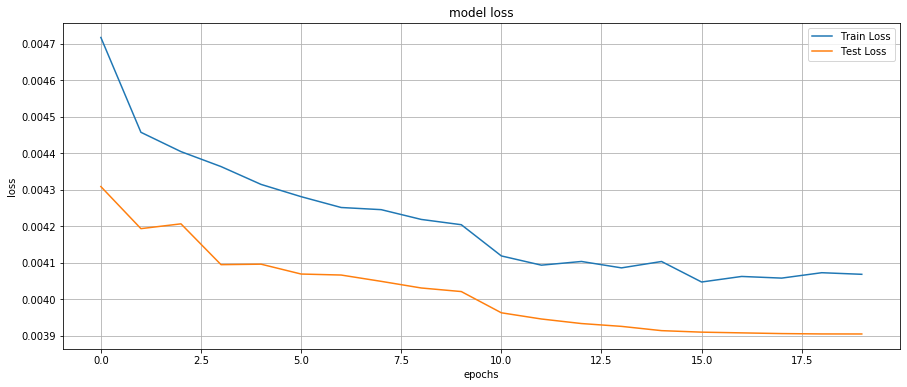

In [20]:
# Muestro grafica de evolucion del error durante el entrenamiento
plt.figure(figsize=(15,6))

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.grid()

plt.show()

In [21]:
# Creo conjuntos de prediccciones
train_predict = model_RN_LSTM.predict(X_train)
test_predict = model_RN_LSTM.predict(X_test)

print(test_predict)

[[0.03475709]
 [0.10172901]
 [0.07111041]
 ...
 [0.05299342]
 [0.03212292]
 [0.02028577]]


In [22]:
# Invierto la transformación del modelo sc (StandardScaler, en este caso MinMaxScaler) 
# para poder tener las predicciones en la escala de los datos en los conjuntos de prueba y entrenamiento
train_predict = sc.inverse_transform(train_predict)
Y_train_lstm = sc.inverse_transform([Y_train])

test_predict = sc.inverse_transform(test_predict)
Y_test_lstm = sc.inverse_transform([Y_test])

print(test_predict)

# Vemos que la ultima prediccion es 1.8741

[[2.850081 ]
 [8.341779 ]
 [5.8310537]
 ...
 [4.34546  ]
 [2.6340792]
 [1.6634332]]


In [23]:
print("Formato Y_test_bd: ", Y_test_lstm.shape)
print("Formato Y_test_bd: ", test_predict.shape)


Formato Y_test_bd:  (1, 1968)
Formato Y_test_bd:  (1968, 1)


In [24]:
# Calculo errores del modelo
from sklearn.metrics import mean_absolute_error

print('Train Mean Absolute Error:', mean_absolute_error(Y_train_lstm[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train_lstm[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test_lstm[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test_lstm[0], test_predict[:,0])))

Train Mean Absolute Error: 2.9557283193118584
Train Root Mean Squared Error: 5.200598087712645
Test Mean Absolute Error: 2.99123994341476
Test Root Mean Squared Error: 5.124187804042958


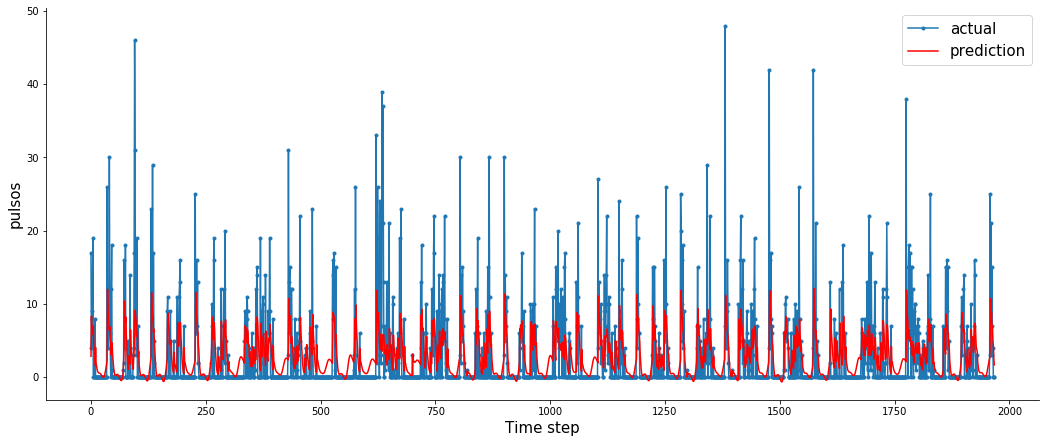

In [25]:
# Grafico de los datos y las predicciones
# No puedo filtrar por fechas porque las he eliminado en los dataset!!

aa=[x for x in range(1968)] # El rango debe coincidir con las dimensiones de las etiquetas. Antes 180 primeros solo

plt.figure(figsize=(15,6))

#plt.plot(aa, Y_test_lstm[0][:180], marker='.', label="actual")
plt.plot(aa, Y_test_lstm[0], marker='.', label="actual")
#plt.plot(aa, test_predict[:,0][:180], 'r', label="prediction")
plt.plot(aa, test_predict[:,0], 'r', label="prediction")

plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)

plt.ylabel('pulsos', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()